### Libraries Importing

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler, MinMaxScaler
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam, SGD
from keras_tuner import RandomSearch
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, classification_report



import matplotlib.pyplot as plt

2024-10-21 12:25:01.363666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 12:25:01.413929: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 12:25:01.414505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 12:25:02.241817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.list_physical_devices('GPU')

2024-10-21 12:25:06.011861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[]

2024-10-21 12:25:06.012362: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Data Preprocessing

In [3]:
# Read Data

dataframe = pd.read_csv('heart_disease_health_indicators.csv')

# Print the first 5 rows

print(dataframe.head())

   HeartDiseaseorAttack  HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
0                     0       1         1          1   40       1       0   
1                     0       0         0          0   25       1       0   
2                     0       1         1          1   28       0       0   
3                     0       1         0          1   27       0       0   
4                     0       1         1          1   24       0       0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0         0             0       0  ...              1            0        5   
1         0             1       0  ...              0            1        3   
2         0             0       1  ...              1            1        5   
3         0             1       1  ...              1            0        2   
4         0             1       1  ...              1            0        2   

   MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  Income  

In [4]:
# print number of heart disease cases and non heart disease cases
dataframe['HeartDiseaseorAttack'].value_counts()


HeartDiseaseorAttack
0    229773
1     23888
Name: count, dtype: int64

In [5]:
# Drop the duplicate rows
dataframe = dataframe.drop_duplicates()

# Drop the rows with missing values
dataframe = dataframe.dropna()

# print number of heart disease cases and non heart disease cases
dataframe['HeartDiseaseorAttack'].value_counts()

HeartDiseaseorAttack
0    206050
1     23712
Name: count, dtype: int64

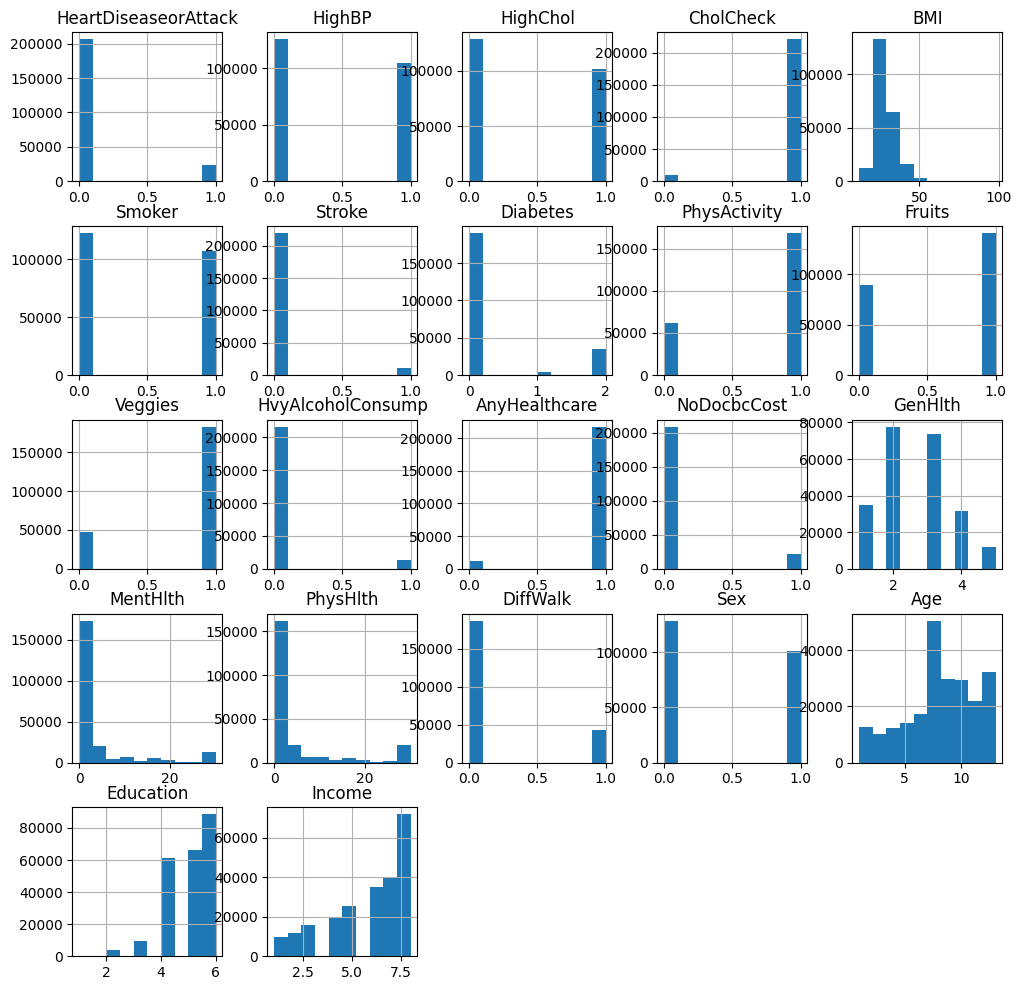

In [6]:
# Plot all the features 
dataframe.hist(figsize=(12, 12))
plt.show()



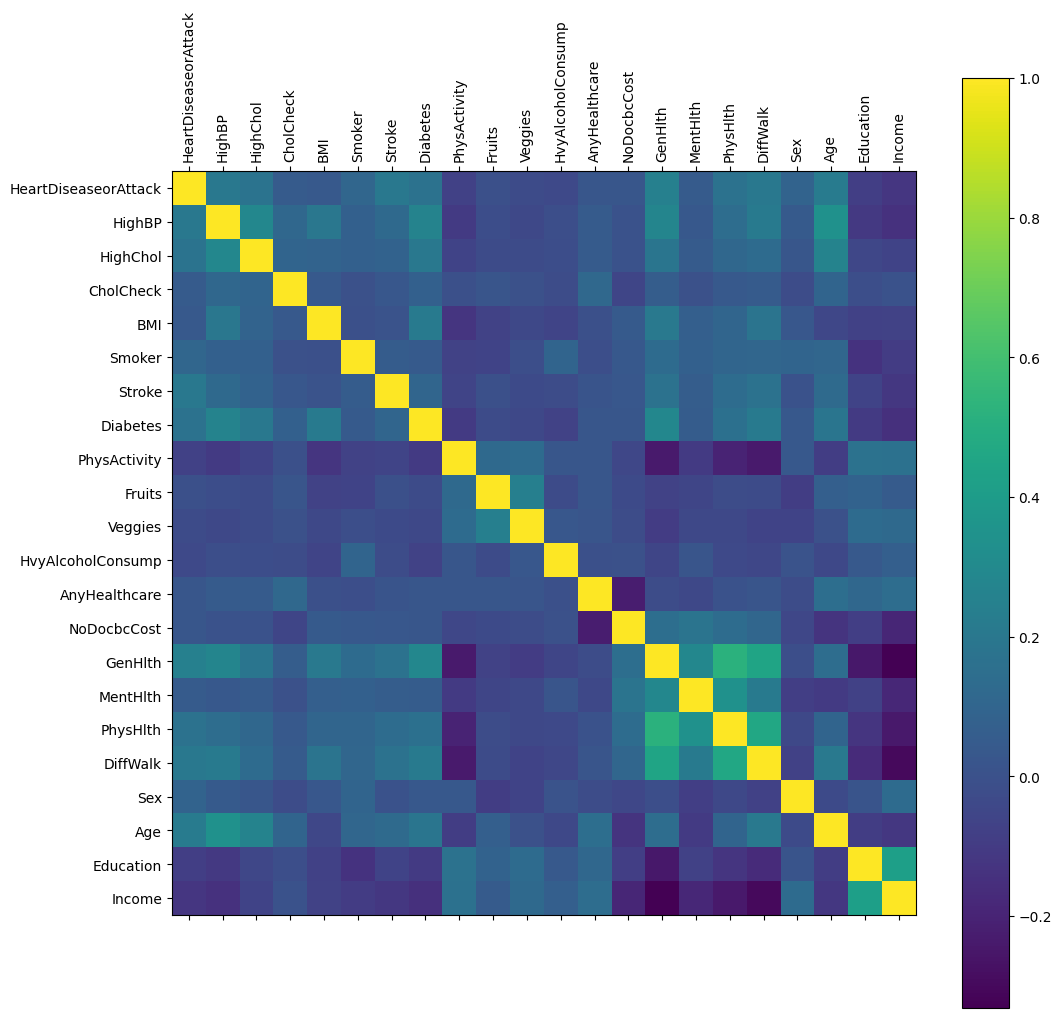

In [7]:
## Plot correlation matrix
corr = dataframe.corr()
plt.figure(figsize=(12, 12))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()




In [8]:

features = dataframe.drop(['HeartDiseaseorAttack'], axis=1)
labels = dataframe['HeartDiseaseorAttack']

In [9]:
# Let all the features on the same scale

scaler_two = StandardScaler()
features = scaler_two.fit_transform(features)


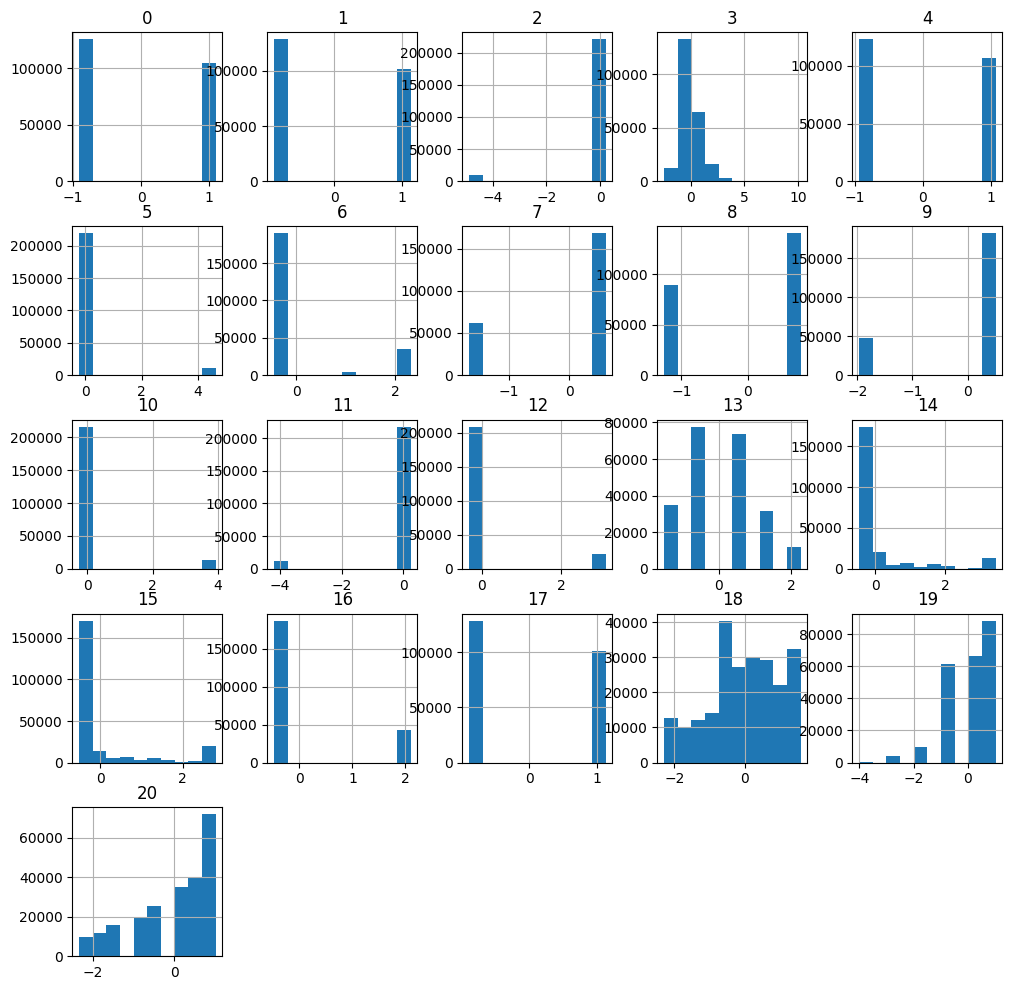

In [10]:
# scaled features dataframe
scaled_dataframe = pd.DataFrame(features)
scaled_dataframe.hist(figsize=(12,12))
plt.show()

In [11]:
## Split the data 


X_train , X_test_val , Y_train, Y_test_val = train_test_split(features, labels , test_size=0.2)
X_test , X_val, Y_test, Y_val = train_test_split(X_test_val, Y_test_val, test_size=0.5)

### Model Building

In [12]:
print(X_train.shape[1])

21


In [13]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_0', 8, 32, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    for i in range(1, hp.Int('num_layers', 0, 3)):  # Tune between 1 and 3 hidden layers
        model.add(Dense(hp.Int('units_' + str(i), 8, 32, step=32), activation='relu'))
        model.add(BatchNormalization())
    
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(optimizer=SGD(hp.Choice('learning_rate', [1e-1,1e-2, 1e-3])), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model



In [14]:
tensorboard = TensorBoard(log_dir='logs', histogram_freq=1)


### Model Compilation

In [15]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

In [16]:
tuner.search(X_train, Y_train, epochs=50,batch_size=64, validation_data=(X_val, Y_val), callbacks=[tensorboard])


Trial 5 Complete [00h 04m 45s]
val_loss: 0.26244056224823

Best val_loss So Far: 0.2607215344905853
Total elapsed time: 00h 29m 20s


In [17]:
best_model = tuner.get_best_models(num_models=1)[0]


In [18]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


In [19]:
print(Y_test)

159813    0
87053     0
22214     0
239587    0
63230     0
         ..
245389    0
155470    0
99824     0
107974    0
129779    0
Name: HeartDiseaseorAttack, Length: 22976, dtype: int64


718/718 [==============================] - 1s 679us/step
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     20634
           1       0.58      0.09      0.15      2342

    accuracy                           0.90     22976
   macro avg       0.74      0.54      0.55     22976
weighted avg       0.87      0.90      0.87     22976



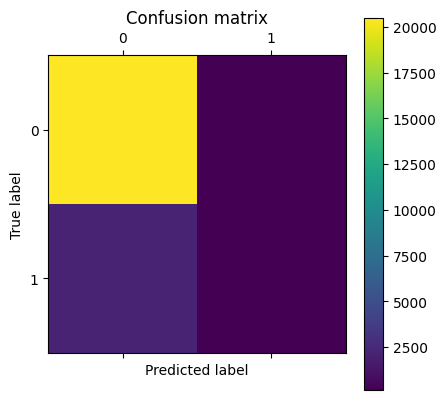

In [20]:
# Test the model
y_preds = best_model.predict(X_test)
y_preds_binary = (y_preds > 0.5).astype(int)
# print classification report
print(classification_report(Y_test, y_preds_binary))

# plot confusion matrix
conf_matrix = confusion_matrix(Y_test, y_preds_binary)
plt.matshow(conf_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


718/718 [==============================] - 1s 681us/step
ROC AUC: 0.8404356762532088


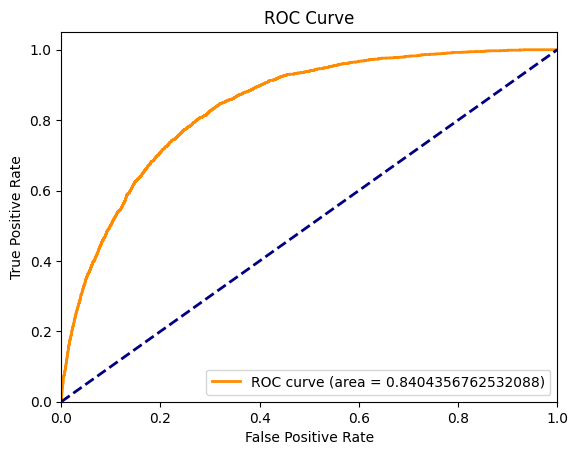

In [21]:
# ROC AUC
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(Y_test, y_pred)
print(f'ROC AUC: {roc_auc}')

# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
